Import Libraries

In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout , SimpleRNN
from sklearn.metrics import mean_squared_error , mean_absolute_error
import matplotlib.pyplot as plt


In this step, we loaded the data and converted it from Excel into a DataFrame. Then we checked whether there were any missing values (there were none). After that, we corrected the column names and finally sorted the data based on the date.

In [59]:
file_path = '/kaggle/input/yahoo-finance-dataset-2018-2023/yahoo_data.xlsx'
df = pd.read_excel(file_path)

df = pd.DataFrame(df)

print(df.columns)

print(df.head())

missing_data = df.isnull().sum()
print("Missing Data:\n", missing_data)

df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close' ,  'Volume']

df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by='Date')

df

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')
           Date      Open      High       Low    Close*  Adj Close**  \
0  Apr 28, 2023  33797.43  34104.56  33728.40  34098.16     34098.16   
1  Apr 27, 2023  33381.66  33859.75  33374.65  33826.16     33826.16   
2  Apr 26, 2023  33596.34  33645.83  33235.85  33301.87     33301.87   
3  Apr 25, 2023  33828.34  33875.49  33525.39  33530.83     33530.83   
4  Apr 24, 2023  33805.04  33891.15  33726.09  33875.40     33875.40   

      Volume  
0  354310000  
1  343240000  
2  321170000  
3  297880000  
4  252020000  
Missing Data:
 Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64


,Date,Open,High,Low,Close,Adj_Close,Volume
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000
...,...,...,...,...,...,...,...
4,2023-04-24,33805.04,33891.15,33726.09,33875.40,33875.40,252020000
3,2023-04-25,33828.34,33875.49,33525.39,33530.83,33530.83,297880000
2,2023-04-26,33596.34,33645.83,33235.85,33301.87,33301.87,321170000
1,2023-04-27,33381.66,33859.75,33374.65,33826.16,33826.16,343240000


Feature Engineering

In this section, we add the monthly and weekly averages to the features so that the model can learn the weekly and monthly relationships of the currencies.


In [60]:
df_feat = df.copy()

df_feat['MA_week'] = df_feat['Close'].rolling(window=7).mean()

for m in [30]:
    df_feat[f'MA_month_{m}'] = df_feat['Close'].rolling(window=m).mean()

df_feat = df_feat.fillna(method='bfill').fillna(method='ffill')

df_feat.head(40)


/tmp/ipykernel_47/895674930.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feat = df_feat.fillna(method='bfill').fillna(method='ffill')


,Date,Open,High,Low,Close,Adj_Close,Volume,MA_week,MA_month_30
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000,24210.965714,24706.398667
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000,24210.965714,24706.398667
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000,24210.965714,24706.398667
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000,24210.965714,24706.398667
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000,24210.965714,24706.398667
1252,2018-05-08,24341.35,24412.34,24198.34,24360.21,24360.21,344940000,24210.965714,24706.398667
1251,2018-05-09,24399.18,24586.48,24323.87,24542.54,24542.54,361580000,24210.965714,24706.398667
1250,2018-05-10,24591.66,24794.99,24575.91,24739.53,24739.53,304210000,24302.462857,24706.398667
1249,2018-05-11,24758.64,24868.65,24717.50,24831.17,24831.17,274150000,24431.918571,24706.398667
1248,2018-05-14,24879.37,24994.19,24862.52,24899.41,24899.41,282860000,24570.384286,24706.398667


Scaling Data with MinMAxScaler

In this section, the data was split into **training (80%)** and **testing (20%)** sets. Then, using the `create_sequences` function, the data was transformed into **60-day time sequences**. The `'Close'` column was selected as the target (label), and the input (`X`) and output (`y`) sequences were created for both the training and testing sets. Finally, the dimensions of the data were checked to ensure that the model's input was properly prepared.


In [61]:
target_col = "Close"

feature_cols = df_feat.columns.drop(['Date'])  

train_size = int(len(df_feat) * 0.8)
train_df = df_feat.iloc[:train_size]
test_df = df_feat.iloc[train_size:]

scaler = MinMaxScaler()
scaler.fit(train_df[feature_cols])

train_scaled = pd.DataFrame(scaler.transform(train_df[feature_cols]), columns=feature_cols)
test_scaled = pd.DataFrame(scaler.transform(test_df[feature_cols]), columns=feature_cols)


def create_sequences(data, seq_len, target_index):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        Y.append(data[i + seq_len, target_index])
    return np.array(X), np.array(Y)

target_index = list(train_scaled.columns).index(target_col)

seq_len = 60

X_train, y_train = create_sequences(train_scaled.values, seq_len, target_index)
X_test, y_test = create_sequences(test_scaled.values, seq_len, target_index)

Here is the English translation:

---

In this section, an **LSTM** model was designed to predict stock prices. The steps for building the model are as follows:

1. **First LSTM layer** with 64 neurons and `return_sequences=True` to output a sequence of data (necessary for the next LSTM layer).
2. **Dropout layer** with a rate of 20% to prevent **overfitting**.
3. **Second LSTM layer** with 32 neurons to extract more complex features from the input data.
4. **Another Dropout layer** to further prevent **overfitting**.
5. **Dense output layer** to predict a single numerical value (the stock price for the next day).

The model was compiled with the **Adam optimizer** and **MSE loss function** to minimize prediction errors.


In [62]:
model_LSTM = Sequential()

model_LSTM.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(32))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1))

model_LSTM.compile(optimizer='adam', loss='mean_squared_error')
model_LSTM.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Train LSTM model

In [63]:
history_LSTM = model_LSTM.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200, 
    batch_size=16
)


Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0739 - val_loss: 0.0024
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - val_loss: 0.0023
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 0.0020
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.

Predict

Model prediction: The LSTM output is still scaled.

Creating a zero-filled array : Used so we can inverse-transform only the **Close** price column.

Inverse-scaling the predictions : Converting the model’s output back to actual price values.

Inverse-scaling `y_test` : Converting the real target values back to their original scale.

Calculating the error : Using MSE and RMSE to evaluate the model’s performance on actual prices.


In [64]:
pred_LSTM_scaled = model_LSTM.predict(X_test)
dummy_LSTM = np.zeros((len(pred_LSTM_scaled), len(feature_cols)))
dummy_LSTM[:, target_index] = pred_LSTM_scaled.flatten()

predictions_LSTM = scaler.inverse_transform(dummy_LSTM)[:, target_index]

dummy_y = np.zeros((len(y_test), len(feature_cols)))
dummy_y[:, target_index] = y_test.flatten()
y_test_actual = scaler.inverse_transform(dummy_y)[:, target_index]

mse_LSTM = mean_squared_error(y_test_actual, predictions_LSTM)
rmse_LSTM = np.sqrt(mse_LSTM)
mae_LSTM = mean_absolute_error(y_test_actual, predictions_LSTM)

print(f"MSE LSTM: {mse_LSTM}")
print(f"RMSE LSTM: {rmse_LSTM}")
print(f"MAE LSTM: {mae_LSTM}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
MSE LSTM: 151770.84188358896
RMSE LSTM: 389.57777385727354
MAE LSTM: 321.5059306345632


* **RNN model created** using `SimpleRNN`.
* **First layer**:
  RNN with 64 neurons and `return_sequences=True` to output to the next layer.
* **Dropout**:
  To prevent overfitting.
* **Second layer**:
  RNN with 32 neurons to capture deeper temporal patterns.
* **Dense output layer**:
  Predicts a single value (price).
* **Model compilation**:
  Using optimizer : adam and loss : MSE.
* **model.summary()**:
  Prints the model structure.


In [65]:
model_RNN = Sequential()

model_RNN.add(SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_RNN.add(Dropout(0.2))  

model_RNN.add(SimpleRNN(32))
model_RNN.add(Dropout(0.2))

model_RNN.add(Dense(1))

model_RNN.compile(optimizer='adam', loss='mean_squared_error')
model_RNN.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 60, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

Train RNN model

In [66]:
history_RNN = model_RNN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,  
    batch_size=16
)

Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.9813 - val_loss: 0.0099
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1761 - val_loss: 0.0448
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1090 - val_loss: 0.0023
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0748 - val_loss: 0.0054
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0657 - val_loss: 0.0124
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0535 - val_loss: 0.0066
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0373 - val_loss: 0.0017
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0329 - val_loss: 0.0124
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0270 - val_loss: 0.0039
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0252 - val_loss: 0.0015
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0231 - val_loss: 0.0027
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0

Model prediction: The RNN output is still scaled.

Creating a zero-filled array : Used so we can inverse-transform only the **Close** price column.

Inverse-scaling the predictions : Converting the model’s output back to actual price values.

Inverse-scaling `y_test` : Converting the real target values back to their original scale.

Calculating the error : Using MSE and RMSE to evaluate the model’s performance on actual prices.


In [67]:
pred_RNN_scaled = model_RNN.predict(X_test)
dummy_RNN = np.zeros((len(pred_RNN_scaled), len(feature_cols)))
dummy_RNN[:, target_index] = pred_RNN_scaled.flatten()

predictions_RNN = scaler.inverse_transform(dummy_RNN)[:, target_index]

dummy_y = np.zeros((len(y_test), len(feature_cols)))
dummy_y[:, target_index] = y_test.flatten()
y_test_actual = scaler.inverse_transform(dummy_y)[:, target_index]

mse_RNN = mean_squared_error(y_test_actual, predictions_RNN)
rmse_RNN = np.sqrt(mse_RNN)
mae_RNN = mean_absolute_error(y_test_actual, predictions_RNN)

print(f"MSE RNN: {mse_RNN}")
print(f"RMSE RNN: {rmse_RNN}")
print(f"MAE RNN: {mae_RNN}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
MSE RNN: 196550.08328743625
RMSE RNN: 443.3396928850791
MAE RNN: 350.0695233312378


1 : First Chart – Comparing Predictions with Actual Prices

This chart plots three lines:

Actual Price (blue)

RNN Model Prediction (green)

LSTM Model Prediction (red)

The goal is to see how closely the models' predictions match the actual price behavior.

2 : Second Chart – Comparing Errors

In this chart:

The RMSE of the RNN model

The RMSE of the LSTM model

These are displayed as a bar chart.

The goal is to determine which model has lower error and better performance.

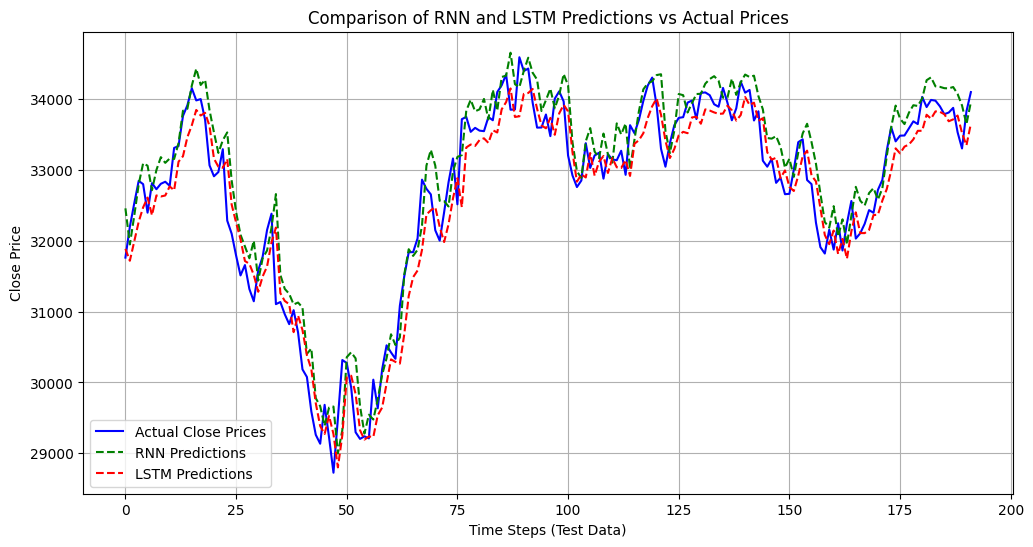

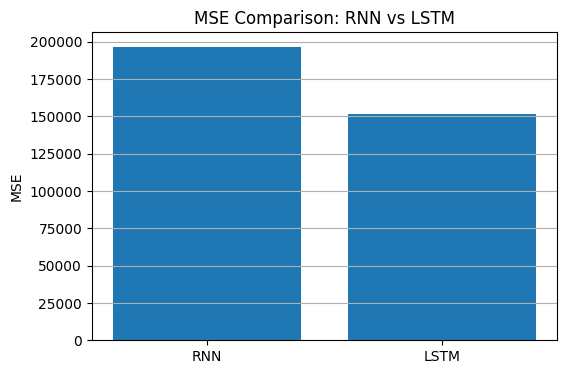

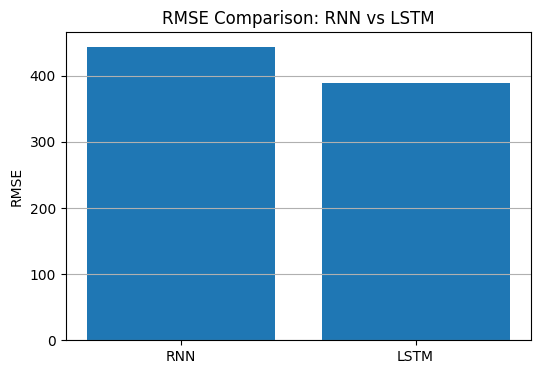

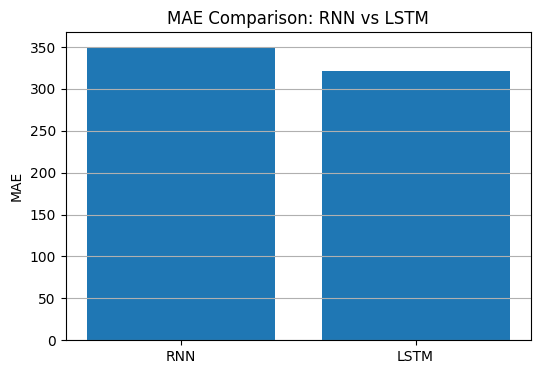

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Close Prices', color='blue')
plt.plot(predictions_RNN, label='RNN Predictions', color='green', linestyle='--')
plt.plot(predictions_LSTM, label='LSTM Predictions', color='red', linestyle='--')
plt.title('Comparison of RNN and LSTM Predictions vs Actual Prices')
plt.xlabel('Time Steps (Test Data)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

models = ['RNN', 'LSTM']

mse_values = [mse_RNN, mse_LSTM]
plt.figure(figsize=(6, 4))
plt.bar(models, mse_values)
plt.title('MSE Comparison: RNN vs LSTM')
plt.ylabel('MSE')
plt.grid(True, axis='y')
plt.show()

rmse_values = [rmse_RNN, rmse_LSTM]
plt.figure(figsize=(6, 4))
plt.bar(models, rmse_values)
plt.title('RMSE Comparison: RNN vs LSTM')
plt.ylabel('RMSE')
plt.grid(True, axis='y')
plt.show()

mae_values = [mae_RNN, mae_LSTM]
plt.figure(figsize=(6, 4))
plt.bar(models, mae_values)
plt.title('MAE Comparison: RNN vs LSTM')
plt.ylabel('MAE')
plt.grid(True, axis='y')
plt.show()


Final Report 

Here is the English translation for the **final report** comparing the performance of the **RNN** and **LSTM** models:

---

### **Final Report on RNN and LSTM Models for Stock Price Prediction**

---

#### **1. Introduction**

In this project, two types of **Recurrent Neural Networks (RNNs)**, including **RNN** and **LSTM**, were trained for stock price prediction using historical data. The goal was to compare the performance of these two models.

---

#### **2. Data and Preprocessing**

The data was collected from **Yahoo Finance** and included information about the **Open**, **Close**, **High**, **Low**, and **Volume** prices for a specific time range. After loading the data:

* The data was split into **training** (80%) and **testing** (20%) sets.
* Additional features like **moving averages** were created to improve model performance.
* The data was scaled using **MinMaxScaler**, and only the numerical features were transformed to the [0, 1] range.

---

#### **3. Models and Architecture**

* Both the **RNN** model and the **LSTM** model were constructed using **SimpleRNN** and **LSTM** layers.
* Both models included **Dropout** layers to prevent **overfitting**.
* The models were compiled using the **Adam optimizer** and **Mean Squared Error (MSE)** as the loss function.

---

#### **4. Results**

After training the models, stock price predictions for the test data were made using both **RNN** and **LSTM** models. The comparative results are as follows:

##### **4.1. Prediction Comparison**

In the **prediction comparison chart**, the actual stock prices (blue) are compared with the predictions of the **RNN** (green) and **LSTM** (red) models. Both models predicted prices similarly, but in some areas, the **LSTM** model showed higher accuracy.

##### **4.2. Comparison of MSE, RMSE, and MAE**

In the **comparison charts of MSE, RMSE, and MAE**:

* The **RMSE** and **MSE** values for the **LSTM** model were slightly lower than those of the **RNN** model, indicating better performance by LSTM.
* The **MAE** for the **LSTM** model was also lower than the **RNN**, meaning less error in predictions.

---

#### **5. Final Analysis**

* **LSTM** generally performed better than **RNN**, as LSTM can better capture long-term dependencies and yields more accurate predictions.
* The **RNN** model also performed well, but its accuracy was slightly lower than LSTM.

---

#### **6. Conclusion**

Based on the results, the **LSTM** model performed better for stock price prediction and provided more accurate results in **long-term** and more complex time-series data.

